In [1]:
!pip install fastai -Uqq

     |████████████████████████████████| 197 kB 21.0 MB/s 
     |████████████████████████████████| 60 kB 7.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/colab_notebooks/algovera/defi/v2

/content/drive/MyDrive/colab_notebooks/algovera/defi/v2


In [4]:
from fastai.tabular.all import *
from tqdm import tqdm
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

SEED=42

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('data/30_compoundV2_mainnet_2021_2022.csv')

In [6]:
df.columns

Index(['id', 'borrowRate', 'cash', 'collateralFactor', 'exchangeRate',
       'interestRateModelAddress', 'name', 'reserves', 'supplyRate', 'symbol',
       'totalBorrows', 'totalSupply', 'underlyingAddress', 'underlyingName',
       'underlyingPrice', 'underlyingSymbol', 'reserveFactor',
       'underlyingPriceUSD', 'timestamp'],
      dtype='object')

In [7]:
dataset = 'compound'

# Prepare data

In [8]:
df1 = pd.DataFrame()
for tok in df.symbol.unique():
    df_tok = df[df['symbol']==tok]
    df_tok = df_tok.drop(['symbol'], axis=1)

    col_names = []
    for col in df_tok.columns:
        if col == 'timestamp':
            col_names.append(f'{col}')
        else:
            col_names.append(f'{tok}_{col}')
        
    df_tok.columns = col_names
    #df_tok = df_tok.set_index('Timestamp', drop=True)
    
    if df1.empty:
        df1 = df_tok
    else:
        df1 = pd.merge(df1, df_tok, on='timestamp')

In [9]:
keep_cols =  [col for col in df1.columns if col.endswith("borrowRate") or col.endswith("supplyRate") or col.endswith("totalBorrows") or col.endswith("totalSupply")]

In [10]:
keep_cols = ['timestamp'] + keep_cols

In [11]:
df1 = df1.copy()[keep_cols]

In [12]:
df1['datetime'] = pd.to_datetime(df1['timestamp'], 
                                utc=True, 
                                unit='s')

In [13]:
df1 = df1.resample('D', on='datetime').mean().reset_index()

In [14]:
df1.head(5)

,datetime,timestamp,cUSDC_borrowRate,cUSDC_supplyRate,cUSDC_totalBorrows,cUSDC_totalSupply,cETH_borrowRate,cETH_supplyRate,cETH_totalBorrows,cETH_totalSupply,cDAI_borrowRate,cDAI_supplyRate,cDAI_totalBorrows,cDAI_totalSupply,cUSDT_borrowRate,cUSDT_supplyRate,cUSDT_totalBorrows,cUSDT_totalSupply
0,2021-01-01 00:00:00+00:00,1.609508e+09,0.083823,0.065259,6.082845e+08,3.386186e+10,0.023489,0.000656,38621.696037,5.530504e+07,0.120937,0.089950,1.009327e+09,5.529674e+10,0.154368,0.129464,8.328638e+07,4.491820e+09
1,2021-01-02 00:00:00+00:00,1.609588e+09,0.084142,0.065686,7.917916e+08,4.393936e+10,0.023383,0.000633,37761.734266,5.572454e+07,0.151570,0.117735,8.430888e+08,4.523187e+10,0.129042,0.106395,8.391469e+07,4.645788e+09
2,2021-01-03 00:00:00+00:00,1.609674e+09,0.107030,0.085882,1.086011e+09,5.916650e+10,0.023395,0.000636,38103.545001,5.607095e+07,0.149435,0.114373,5.643168e+08,2.999728e+10,0.176392,0.153259,9.097184e+07,4.797619e+09
3,2021-01-04 00:00:00+00:00,1.609761e+09,0.075913,0.058859,7.405559e+08,4.156061e+10,0.023334,0.000623,36575.023917,5.491996e+07,0.100941,0.075029,7.802695e+08,4.381163e+10,0.159115,0.135205,1.021338e+08,5.484576e+09
4,2021-01-05 00:00:00+00:00,1.609847e+09,0.077461,0.059802,6.599494e+08,3.696463e+10,0.023523,0.000663,36256.294559,5.136644e+07,0.062356,0.043513,8.357338e+08,4.872078e+10,0.165853,0.142365,1.096788e+08,5.848212e+09


In [15]:
df1.columns

Index(['datetime', 'timestamp', 'cUSDC_borrowRate', 'cUSDC_supplyRate',
       'cUSDC_totalBorrows', 'cUSDC_totalSupply', 'cETH_borrowRate',
       'cETH_supplyRate', 'cETH_totalBorrows', 'cETH_totalSupply',
       'cDAI_borrowRate', 'cDAI_supplyRate', 'cDAI_totalBorrows',
       'cDAI_totalSupply', 'cUSDT_borrowRate', 'cUSDT_supplyRate',
       'cUSDT_totalBorrows', 'cUSDT_totalSupply'],
      dtype='object')

In [16]:
df_train = df1[df1['datetime'] <= '2021-12-31'].copy()

# Utility functions

In [34]:
def get_tabpandas_multi(
    df:pd.DataFrame, # Dataframe of the raw data 
    n_timepoint:int, # Number of previous timepoints to be used as features   
    target_window:int, # Number of timepoints in the future to predict 
    inference:bool=False, # Flag True for inference
):

    df = df.reset_index(drop=True)
    feature_cols = [
              'cUSDC_borrowRate',
              'cUSDC_supplyRate',
              'cUSDC_totalBorrows',
              'cUSDC_totalSupply',
              'cETH_borrowRate',
              'cETH_supplyRate',
              'cETH_totalBorrows',
              'cETH_totalSupply',
              'cDAI_borrowRate',
              'cDAI_supplyRate',
              'cDAI_totalBorrows',
              'cDAI_totalSupply',
              'cUSDT_borrowRate',
              'cUSDT_supplyRate',
              'cUSDT_totalBorrows',
              'cUSDT_totalSupply']

    target_columns = ['cUSDC_borrowRate', 'cDAI_borrowRate', 'cUSDT_borrowRate']

    target = 'target'

    cols_names = []
    for j in range(n_timepoint):
        for col in feature_cols:
            cols_names.append(f'{col}_t-{n_timepoint -j-1}')
    cols_names += [target]

    pairs = []
    for i, row in tqdm(df.iterrows()):
        if i < (len(df)-target_window-n_timepoint-1):
            features = df.loc[i:i+n_timepoint-1, feature_cols].values
            features = [item for sublist in features for item in sublist]

            val =  df.loc[i+n_timepoint: i+n_timepoint-1+target_window, target_columns].mean().idxmin()

            features += [val]
            pairs.append(features)

    df = pd.DataFrame(pairs, columns=cols_names).dropna().reset_index(drop=True)
    
    if not inference:
        x = df.iloc[:, :-1]
        y = df.iloc[:, -1]

        x_train, x_test, y_train, y_test = train_test_split(x, 
                                                            y, 
                                                            test_size=0.2, 
                                                            random_state=SEED)

        ss = StandardScaler()
        x_train = ss.fit_transform(x_train)
        x_test = ss.transform(x_test)

        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_test = le.transform(y_test)

        return df, x_train, x_test, y_train, y_test, ss, le 

    if inference:
        return df


def plot_confusion_matrix(
    preds,
    targs,
    le,
):
    cm = confusion_matrix(targs, 
                          preds, 
                          normalize=None)
    
    df_cm = pd.DataFrame(cm, 
                         columns=le.classes_, 
                         index=le.classes_)
    
    sns.heatmap(df_cm, 
                annot=True, 
                annot_kws={"size": 16},
                cmap="Blues")
    
    plt.show()

    print(f"accuracy score: {accuracy_score(targs, preds)}")


def save_models(
    ntp,
    tw,
    ss,
    le,
    clf,
    dataset,
):

    save_pickle(f'models/{dataset}_ss_rfc_{ntp}_{tw}.pkl', ss)
    save_pickle(f'models/{dataset}_le_rfc_{ntp}_{tw}.pkl', le)
    save_pickle(f'models/{dataset}_rfc_{ntp}_{tw}.pkl', clf)


def load_models(
    ntp,
    tw,
    dataset,  
):
    ss = load_pickle(f'models/{dataset}_ss_rfc_{ntp}_{tw}.pkl')
    le = load_pickle(f'models/{dataset}_le_rfc_{ntp}_{tw}.pkl')
    clf = load_pickle(f'models/{dataset}_rfc_{ntp}_{tw}.pkl')

    return ss, le, clf


def run_test(
    ntp,
    tw,
    df_test,
    dataset,
):
    df = df_test.copy()
    x_test = df.iloc[:, :-1].values

    ss, le, clf = load_models(ntp, tw, dataset)
    
    x_test = ss.transform(x_test)
    
    pred = clf.predict(x_test)
    pred = le.classes_[pred]
    
    df['preds'] = pred
    
    print(f"Accuracy score: {accuracy_score(df['target'].values, pred)}")

    return df, accuracy_score(df['target'].values, pred)


def strategy_cost(row):
    return row[row.Predict] * row['Borrow Amount']/365

def compare_strategy(ntp, tw, initial_borrow, df):

    ss, le, clf = load_models(ntp, tw, 'compound')

    chunks = []
    for i, v in enumerate(range(0, len(df), tw)):
        if i == 0:
            chunks.append(df.loc[:ntp+tw-1].copy().reset_index(drop=True))
        else:
            chunks.append(df.loc[v:v+ntp+tw-1].copy().reset_index(drop=True))

    for i, chu in enumerate(chunks):
        if len(chu) == ntp+tw:
            x = np.array(chu.iloc[:ntp, :].values.reshape(1, -1))
            x = ss.transform(x)
            pred = clf.predict(x)
            pred = le.classes_[pred]

            chu.loc[ntp:, 'Predict'] = pred[0]  
            if i == 0:
                final = chu.dropna()
            else:
                final = final.append(chu.dropna()).reset_index(drop=True)

    final['Borrow Amount'] = initial_borrow

    final['DAI_br_cost'] = final['cDAI_borrowRate'] * final['Borrow Amount']/365
    final['USDC_br_cost'] = final['cUSDC_borrowRate'] * final['Borrow Amount']/365
    final['USDT_br_cost'] = final['cUSDT_borrowRate'] * final['Borrow Amount']/365


    final['Strategy_br_cost'] = final.apply(lambda row: strategy_cost(row), axis=1)

    return final

In [35]:
len(df1)

495

In [36]:
df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7)

44it [00:00, 210.17it/s]

(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)


91it [00:00, 223.75it/s]

(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)

114it [00:00, 223.57it/s]


(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)


162it [00:00, 221.33it/s]

(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)

211it [00:00, 230.50it/s]


(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)


259it [00:01, 219.43it/s]

(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)


306it [00:01, 225.82it/s]

(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)

355it [00:01, 235.18it/s]


(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)


404it [00:01, 237.00it/s]

(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)


458it [00:01, 250.14it/s]

(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)


495it [00:02, 233.49it/s]

(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)


In [32]:
df.head()

,cUSDC_borrowRate_t-4,cUSDC_supplyRate_t-4,cUSDC_totalBorrows_t-4,cUSDC_totalSupply_t-4,cETH_borrowRate_t-4,cETH_supplyRate_t-4,cETH_totalBorrows_t-4,cETH_totalSupply_t-4,cDAI_borrowRate_t-4,cDAI_supplyRate_t-4,...,cETH_totalSupply_t-0,cDAI_borrowRate_t-0,cDAI_supplyRate_t-0,cDAI_totalBorrows_t-0,cDAI_totalSupply_t-0,cUSDT_borrowRate_t-0,cUSDT_supplyRate_t-0,cUSDT_totalBorrows_t-0,cUSDT_totalSupply_t-0,target
0,0.083823,0.065259,6.082845e+08,3.386186e+10,0.023489,0.000656,38621.696037,5.530504e+07,0.120937,0.089950,...,5.136644e+07,0.062356,0.043513,8.357338e+08,4.872078e+10,0.165853,0.142365,1.096788e+08,5.848212e+09,cDAI_borrowRate
1,0.084142,0.065686,7.917916e+08,4.393936e+10,0.023383,0.000633,37761.734266,5.572454e+07,0.151570,0.117735,...,5.139967e+07,0.075207,0.053216,8.487926e+08,4.877830e+10,0.121064,0.098136,1.147726e+08,6.394851e+09,cDAI_borrowRate
2,0.107030,0.085882,1.086011e+09,5.916650e+10,0.023395,0.000636,38103.545001,5.607095e+07,0.149435,0.114373,...,5.052063e+07,0.084545,0.060430,8.739699e+08,4.970513e+10,0.132977,0.109196,1.245461e+08,6.852136e+09,cDAI_borrowRate
3,0.075913,0.058859,7.405559e+08,4.156061e+10,0.023334,0.000623,36575.023917,5.491996e+07,0.100941,0.075029,...,4.996384e+07,0.075418,0.053411,8.967449e+08,5.151562e+10,0.134736,0.110640,1.309321e+08,7.187512e+09,cDAI_borrowRate
4,0.077461,0.059802,6.599494e+08,3.696463e+10,0.023523,0.000663,36256.294559,5.136644e+07,0.062356,0.043513,...,4.901571e+07,0.063330,0.044223,9.548078e+08,5.557142e+10,0.068049,0.051766,1.201290e+08,7.298077e+09,cDAI_borrowRate


In [30]:
len(df)

482

# n_timepoints = 5, Target_window = 7




365it [00:00, 733.30it/s]


cDAI_borrowRate     155
cUSDC_borrowRate    134
cUSDT_borrowRate     63
Name: target, dtype: int64

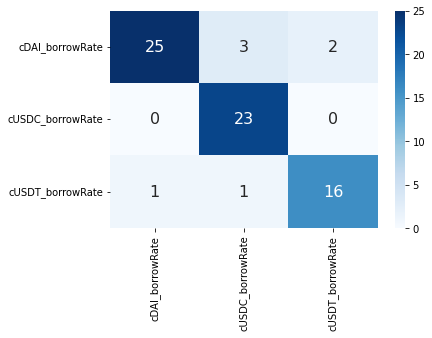

accuracy score: 0.9014084507042254


In [ ]:
ntp = 5
tw = 7

df, x_train, x_test, y_train, y_test, ss, le = get_tabpandas_multi(df_train, ntp, tw)
display(df['target'].value_counts())

clf = RandomForestClassifier(n_estimators=90, random_state=SEED)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)
plot_confusion_matrix(y_test, preds, le)
save_models(ntp, tw, ss, le, clf, dataset)

# n_timepoints = 5, Target_window = 14


365it [00:00, 373.67it/s]


cDAI_borrowRate     163
cUSDC_borrowRate    133
cUSDT_borrowRate     49
Name: target, dtype: int64


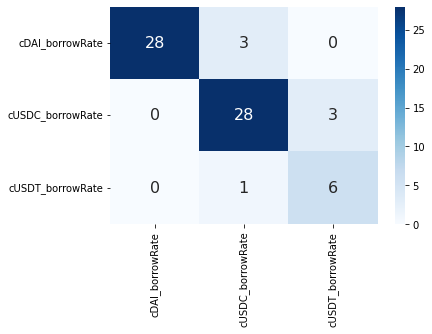

accuracy score: 0.8985507246376812


In [ ]:
ntp = 5
tw = 14

df, x_train, x_test, y_train, y_test, ss, le = get_tabpandas_multi(df_train, ntp, tw)
print(df['target'].value_counts())

clf = RandomForestClassifier(n_estimators=90, random_state=SEED)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)
plot_confusion_matrix(y_test, preds, le)
save_models(ntp, tw, ss, le, clf, dataset)

# n_timepoints = 5, Target_window = 21

365it [00:00, 374.32it/s]


cDAI_borrowRate     168
cUSDC_borrowRate    144
cUSDT_borrowRate     26
Name: target, dtype: int64


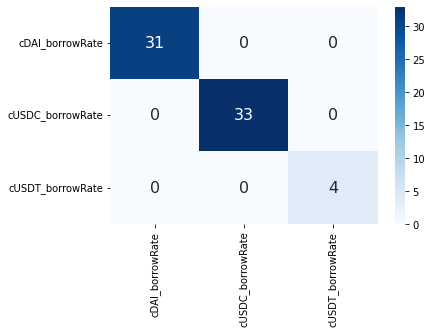

accuracy score: 1.0


In [ ]:
ntp = 5
tw = 21

df, x_train, x_test, y_train, y_test, ss, le = get_tabpandas_multi(df_train, ntp, tw)
print(df['target'].value_counts())

clf = RandomForestClassifier(n_estimators=90, random_state=SEED)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)
plot_confusion_matrix(y_test, preds, le)
save_models(ntp, tw, ss, le, clf, dataset)

# n_timepoints = 5, Target_window = 28




365it [00:00, 466.43it/s]


cDAI_borrowRate     179
cUSDC_borrowRate    127
cUSDT_borrowRate     25
Name: target, dtype: int64


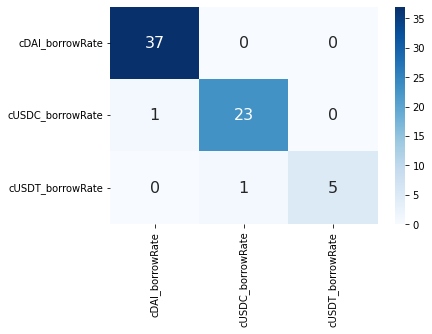

accuracy score: 0.9701492537313433


In [ ]:
ntp = 5
tw = 28

df, x_train, x_test, y_train, y_test, ss, le = get_tabpandas_multi(df_train, ntp, tw)
print(df['target'].value_counts())

clf = RandomForestClassifier(n_estimators=90, random_state=SEED)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)
plot_confusion_matrix(y_test, preds, le)
save_models(ntp, tw, ss, le, clf, dataset)

# n_timepoints = 5, Target_window = 56


365it [00:00, 372.61it/s]


cDAI_borrowRate     157
cUSDC_borrowRate    119
cUSDT_borrowRate     27
Name: target, dtype: int64


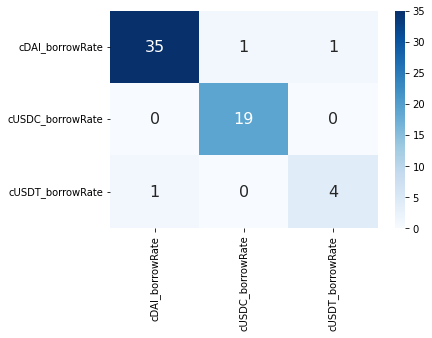

accuracy score: 0.9508196721311475


In [ ]:
ntp = 5
tw = 56

df, x_train, x_test, y_train, y_test, ss, le = get_tabpandas_multi(df_train, ntp, tw)
print(df['target'].value_counts())

clf = RandomForestClassifier(n_estimators=90, random_state=SEED)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)
plot_confusion_matrix(y_test, preds, le)
save_models(ntp, tw, ss, le, clf, dataset)

## Test set

In [ ]:
df_test = df1[df1['datetime'] > '2021-12-31'].reset_index(drop=True)
df_test = df_test.iloc[:, 2:]

In [ ]:
df_test = get_tabpandas_multi(df_test, 5, 7, inference=True)


130it [00:00, 876.28it/s]


In [ ]:
df_test['target'].value_counts()

cUSDC_borrowRate    79
cUSDT_borrowRate    38
Name: target, dtype: int64

In [ ]:
df_t, acc = run_test(5, 7, df_test, 'compound')

Accuracy score: 0.6581196581196581


In [ ]:
df_t['preds'].value_counts()

cUSDC_borrowRate    114
cDAI_borrowRate       3
Name: preds, dtype: int64

In [ ]:
df_t, acc = run_test(5, 14, df_test, 'compound')

Accuracy score: 0.6581196581196581


In [ ]:
df_t['preds'].value_counts()

cUSDC_borrowRate    114
cDAI_borrowRate       3
Name: preds, dtype: int64

In [ ]:
df_t, acc = run_test(5, 21, df_test, 'compound')

Accuracy score: 0.6581196581196581


In [ ]:
df_t['preds'].value_counts()

cUSDC_borrowRate    114
cDAI_borrowRate       3
Name: preds, dtype: int64

In [ ]:
df_t, acc = run_test(5, 28, df_test, 'compound')

Accuracy score: 0.6752136752136753


In [ ]:
df_t['preds'].value_counts()

cUSDC_borrowRate    117
Name: preds, dtype: int64

# Comparing Strategies 

In [ ]:
df_test = df1[df1['datetime'] > '2021-12-31'].reset_index(drop=True)
df_test = df_test.iloc[:, 2:]

In [ ]:
df_test


,cUSDC_borrowRate,cUSDC_supplyRate,cUSDC_totalBorrows,cUSDC_totalSupply,cETH_borrowRate,cETH_supplyRate,cETH_totalBorrows,cETH_totalSupply,cDAI_borrowRate,cDAI_supplyRate,cDAI_totalBorrows,cDAI_totalSupply,cUSDT_borrowRate,cUSDT_supplyRate,cUSDT_totalBorrows,cUSDT_totalSupply
0,0.038035,0.026763,2.202141e+09,1.290367e+11,0.023582,0.000676,51606.128280,7.178977e+07,0.038920,0.025751,2.767247e+09,1.630991e+11,0.039057,0.028221,6.490461e+08,3.838895e+10
1,0.037919,0.026600,2.182139e+09,1.282442e+11,0.023642,0.000689,51156.867936,7.000625e+07,0.038782,0.025569,2.729932e+09,1.614579e+11,0.038952,0.028070,6.501464e+08,3.855337e+10
2,0.038041,0.026771,2.254708e+09,1.320758e+11,0.023689,0.000699,51731.981317,6.988984e+07,0.038757,0.025536,2.719417e+09,1.609285e+11,0.039132,0.028329,6.529886e+08,3.854097e+10
3,0.038350,0.027210,2.267655e+09,1.317567e+11,0.023742,0.000711,52355.296981,6.972685e+07,0.038792,0.025583,2.713582e+09,1.604228e+11,0.038775,0.027815,6.531714e+08,3.890430e+10
4,0.038988,0.028123,2.264716e+09,1.294268e+11,0.023740,0.000711,52322.633681,6.972313e+07,0.038656,0.025403,2.691906e+09,1.596914e+11,0.038817,0.027876,6.548894e+08,3.896216e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.026670,0.013188,8.123104e+08,6.740775e+10,0.021869,0.000327,15826.806289,4.220638e+07,0.027935,0.013279,5.344100e+08,4.345197e+10,0.026560,0.013051,4.260133e+08,3.674360e+10
126,0.024587,0.011183,7.491232e+08,6.741628e+10,0.021853,0.000324,15177.816600,4.079745e+07,0.029357,0.014651,6.003305e+08,4.649822e+10,0.027091,0.013578,4.342068e+08,3.671476e+10
127,0.024633,0.011228,7.300020e+08,6.556697e+10,0.022087,0.000371,17272.221266,4.116101e+07,0.029648,0.014945,6.016799e+08,4.614266e+10,0.026797,0.013287,4.275673e+08,3.654891e+10
128,0.022853,0.009672,6.670280e+08,6.454562e+10,0.022390,0.000428,19872.214799,4.140924e+07,0.030498,0.015816,6.243889e+08,4.655352e+10,0.024344,0.010995,3.850310e+08,3.621468e+10


In [ ]:
final_7 = compare_strategy(5, 7, 1000000, df_test)

    cUSDC_borrowRate  cUSDC_supplyRate  cUSDC_totalBorrows  cUSDC_totalSupply  \
0           0.038035          0.026763        2.202141e+09       1.290367e+11   
1           0.037919          0.026600        2.182139e+09       1.282442e+11   
2           0.038041          0.026771        2.254708e+09       1.320758e+11   
3           0.038350          0.027210        2.267655e+09       1.317567e+11   
4           0.038988          0.028123        2.264716e+09       1.294268e+11   
5           0.039011          0.028155        2.217614e+09       1.266394e+11   
6           0.038039          0.026778        2.177728e+09       1.275680e+11   
7           0.036982          0.025302        2.221171e+09       1.337787e+11   
8           0.036745          0.024979        2.192212e+09       1.328759e+11   
9           0.036868          0.025146        2.169008e+09       1.310278e+11   
10          0.036979          0.025298        2.134692e+09       1.285523e+11   
11          0.037011        

In [ ]:
final_7.iloc[:, -4:].sum()

DAI_br_cost         11945.287899
USDC_br_cost        10282.647293
USDT_br_cost        11150.160574
Strategy_br_cost    10298.779504
dtype: float64

In [ ]:
final_14 = compare_strategy(5, 14, 1000000, df_test)

In [ ]:
final_14.iloc[:, -4:].sum()

DAI_br_cost         11280.282167
USDC_br_cost         9739.879276
USDT_br_cost        10601.084264
Strategy_br_cost     9766.105117
dtype: float64

In [ ]:
final_21 = compare_strategy(5, 21, 1000000, df_test)

In [ ]:
final_21.iloc[:, -4:].sum()

DAI_br_cost         10548.358873
USDC_br_cost         9108.804346
USDT_br_cost        10032.388177
Strategy_br_cost     9228.262975
dtype: float64

In [ ]:
final_28 = compare_strategy(5, 28, 1000000, df_test)

In [ ]:
final_28.iloc[:, -4:].sum()

DAI_br_cost         11280.282167
USDC_br_cost         9739.879276
USDT_br_cost        10601.084264
Strategy_br_cost     9739.879276
dtype: float64